In [1]:

NUM_PROC_MAP = 150 # expect 30 min with single process
PUSH_TO_HF = False

DEBUG = True
EPOCHS = 10
HF_USERNAME = None

import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

import numpy as np

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import plotting
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset




DEBUG = True

import torch
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from baseline_curricula import validate_training_duration_limitation
from itertools import product, chain
import config 
from util import get_curriculum

jobs =[(dataset, curriculum,model_type) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
jobs.extend([(dataset, model_type + curriculum,model_type) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])


In [2]:
from util import get_curriculum


In [3]:

from itertools import product
import config 

In [4]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
word_count = lambda d: {"words": len(d["text"].split())}
cache_path = (os.path.join("./plotting_notebooks/cache/","curricula_metrics_counts.pkl"))


def get_tokens_seen(word_counts_dataset, curriculum):
    indices = torch.cat(curriculum).flatten().tolist()
    selected = word_counts_dataset.select(indices)
    return selected["words"]

if not os.path.exists(cache_path):
    dataset_cache = {}
    unique_datasets = set(dataset for dataset, _,_ in jobs)

    # Preprocess and cache each dataset once
    for dataset_name in tqdm(unique_datasets, desc="Preprocessing datasets"):
        dataset = load_dataset(dataset_name)["train"]
        word_counts_dataset = dataset.map(word_count, num_proc=100)
        dataset_cache[dataset_name] = {
            "word_counts": word_counts_dataset,

        }

    def process_experiment(args):
        dataset_name, curriculum_name, model_type,  data_info = args
        curriculum = get_curriculum(dataset_name, curriculum_name)
        
        r = {
            "dataset": dataset_name,
            "model_type": model_type,
            "curriculum": curriculum_name,
            "tokens seen by model": get_tokens_seen(data_info["word_counts"], curriculum),
        }
        # print( r, flush=True)
        return r

    job_args = [(dataset, curriculum, model_type, dataset_cache[dataset]) for dataset, curriculum, model_type in jobs]

    with Pool(10) as pool:
        results = list(tqdm(pool.imap(process_experiment, job_args), total=len(job_args)))

    df = pd.DataFrame(results)
    df.to_pickle(cache_path)

else:
    print("Reusing cached results")

df = pd.read_pickle(cache_path)


Preprocessing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Map (num_proc=100):   0%|          | 0/100000 [00:00<?, ? examples/s]

Preprocessing datasets:  33%|███▎      | 1/3 [00:07<00:14,  7.10s/it]

Map (num_proc=100):   0%|          | 0/1179014 [00:00<?, ? examples/s]

Preprocessing datasets:  67%|██████▋   | 2/3 [00:14<00:06,  6.99s/it]

Map (num_proc=100):   0%|          | 0/1070321 [00:00<?, ? examples/s]

100%|██████████| 84/84 [05:43<00:00,  4.09s/it] 


In [5]:
df["tokens seen by model"] = df["tokens seen by model"].apply(lambda x: [np.mean(a) for a in np.array_split(x,1000)])

In [6]:
import util
df["curriculum"] = df["curriculum"].apply(util.rename)
df["dataset"] = df["dataset"].apply(util.rename_dataset)

In [7]:
df

,dataset,model_type,curriculum,tokens seen by model
0,$D_{2024}$,llama,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464..."
1,$D_{2024}$,llama,$C_{source}$,"[4.843928539040537, 4.9150267525165505, 4.8829..."
2,$D_{2024}$,llama,$C_{MATTR}$,"[6.288440335849376, 6.639470782800441, 6.67814..."
3,$D_{2024}$,llama,$C_{PPL}$,"[0.0, 1.523450089050971, 1.997879738783818, 1...."
4,$D_{2024}$,roberta,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464..."
...,...,...,...,...
79,$D_{stratified}$,roberta,$(C*h)^{\sim}_{\searrow}$,"[2.0, 2.678251121076233, 5.656857249626308, 5...."
80,$D_{stratified}$,roberta,$C_\nearrow$,"[5.622103886397609, 6.906576980568012, 7.80979..."
81,$D_{stratified}$,roberta,$C_{\searrow}$,"[2.0, 2.666479820627803, 5.6674140508221225, 5..."
82,$D_{stratified}$,roberta,$C^{\{50\}}_{\nearrow}$,"[11.622591839176739, 11.707311236089506, 11.65..."


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_tokens_over_time(df, save_path="./autogenerated_figures/tokens_over_time_facet_grid.pdf"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    df_exploded = df[ (df["dataset"] != "$D_{equitoken}$")].explode('tokens seen by model').reset_index(drop=True)

    g = sns.FacetGrid(df_exploded, row="dataset", col="curriculum", height=5, aspect=1.5, sharey=True, margin_titles=True)

    def plot_func(data, **kwargs):
        x = data.groupby('model_type').cumcount()
        sns.lineplot(x=x, y=data['tokens seen by model'], hue=data['model_type'], markers=False, palette="Set2", legend="full", linewidth=0.7, **kwargs)

    g.map_dataframe(plot_func)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ax in g.axes.flat:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])

    g.fig.text(0.5, -0.10, 'Time $\\rightarrow$', ha='center', fontsize=12, fontweight='bold')
    g.fig.text(-0.02, 0.5, 'Tokens per doc', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    g.fig.subplots_adjust(wspace=0)
    g.fig.subplots_adjust(hspace=0)

    g.fig.set_size_inches(10, 2.5)
    g.tight_layout(pad=0)

    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

plot_tokens_over_time(df)


In [ ]:
df

,dataset,model_type,curriculum,tokens seen by model
0,$D_{2024}$,llama,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464..."
1,$D_{2024}$,llama,$C_{source}$,"[4.843928539040537, 4.9150267525165505, 4.8829..."
2,$D_{2024}$,llama,$C_{MATTR}$,"[6.288440335849376, 6.639470782800441, 6.67814..."
3,$D_{2024}$,llama,$C_{PPL}$,"[0.0, 1.523450089050971, 1.997879738783818, 1...."
4,$D_{2024}$,roberta,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464..."
...,...,...,...,...
73,$D_{stratified}$,roberta,$(C*h)^{\sim}_{\searrow}$,"[2.0, 2.678251121076233, 5.656857249626308, 5...."
74,$D_{stratified}$,roberta,$C_\nearrow$,"[5.622103886397609, 6.906576980568012, 7.80979..."
75,$D_{stratified}$,roberta,$C_{\searrow}$,"[2.0, 2.666479820627803, 5.6674140508221225, 5..."
76,$D_{stratified}$,roberta,$C^{\{50\}}_{\nearrow}$,"[11.622591839176739, 11.707311236089506, 11.65..."


In [ ]:


df["tokens seen by model var"] = df['tokens seen by model'].apply(np.var)
pd.DataFrame(df.groupby(["curriculum"])['tokens seen by model var'].mean().sort_values())

,tokens seen by model var
curriculum,
$C_{rand}$,0.016459
$C^{\{50\}}_{\nearrow}$,0.053508
$C^E_{\searrow}$,8.696754
$(C*h)^{\sim}_{\searrow}$,10.043257
$(C*h)^{\sim}_{\nearrow}$,10.045464
$C_{A}$,11.342172
$C^{\sim}_{\searrow}$,14.028205
$C_{\searrow}$,14.032502
$C^{\sim}_{\nearrow}$,14.034546


In [ ]:
df

,dataset,model_type,curriculum,tokens seen by model,tokens seen by model var
0,$D_{2024}$,llama,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464...",0.022626
1,$D_{2024}$,llama,$C_{source}$,"[4.843928539040537, 4.9150267525165505, 4.8829...",65.270174
2,$D_{2024}$,llama,$C_{MATTR}$,"[6.288440335849376, 6.639470782800441, 6.67814...",34.491961
3,$D_{2024}$,llama,$C_{PPL}$,"[0.0, 1.523450089050971, 1.997879738783818, 1....",59.347058
4,$D_{2024}$,roberta,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464...",0.022626
...,...,...,...,...,...
73,$D_{stratified}$,roberta,$(C*h)^{\sim}_{\searrow}$,"[2.0, 2.678251121076233, 5.656857249626308, 5....",13.052543
74,$D_{stratified}$,roberta,$C_\nearrow$,"[5.622103886397609, 6.906576980568012, 7.80979...",30.239061
75,$D_{stratified}$,roberta,$C_{\searrow}$,"[2.0, 2.666479820627803, 5.6674140508221225, 5...",30.208460
76,$D_{stratified}$,roberta,$C^{\{50\}}_{\nearrow}$,"[11.622591839176739, 11.707311236089506, 11.65...",0.060383


In [ ]:
benchmark_results = pd.read_pickle("./plotting_notebooks/cache/benchmark_results.pkl")
benchmark_results

,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,dataset,curriculum,model_type
44,$C^E_{\nearrow}$,0.486742,0.630457,9.813635e-06,-14.371556,True,-13.158646,-14.37\%***,$D_{equitoken}$,$C^E_{\nearrow}$,Llama
24,$C^E_{\nearrow}$,0.527150,0.631135,3.183010e-06,-10.398497,True,-9.488725,-10.40\%***,$D_{2024}$,$C^E_{\nearrow}$,Llama
64,$C^E_{\nearrow}$,0.564281,0.644914,3.208876e-10,-8.063287,True,-2.493422,-8.06\%***,$D_{stratified}$,$C^E_{\nearrow}$,Llama
65,$C^E_{\searrow}$,0.586505,0.644914,5.841027e-07,-5.840890,True,-0.271025,-5.84\%***,$D_{stratified}$,$C^E_{\searrow}$,Llama
45,$C^E_{\searrow}$,0.574261,0.630457,4.005967e-05,-5.619637,True,-4.406727,-5.62\%***,$D_{equitoken}$,$C^E_{\searrow}$,Llama
...,...,...,...,...,...,...,...,...,...,...,...
43,$C_{A}$,0.566731,0.496967,1.017621e-02,6.976413,True,-0.375249,+6.98\%**,$D_{2024}$,$C_{A}$,RoBERTa
6,$C_{MATTR}$,0.570238,0.496967,7.654461e-03,7.327153,True,-0.024509,+7.33\%***,$D_{2024}$,$C_{MATTR}$,RoBERTa
5,$C_{source}$,0.570484,0.496967,7.693906e-03,7.351662,True,0.000000,+7.35\%***,$D_{2024}$,$C_{source}$,RoBERTa
42,$C^{\{50\}}_{\nearrow}$,0.574034,0.496967,4.997527e-03,7.706720,True,0.355058,+7.71\%***,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa


In [ ]:
df

,dataset,model_type,curriculum,tokens seen by model,tokens seen by model var
0,$D_{2024}$,llama,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464...",0.022626
1,$D_{2024}$,llama,$C_{source}$,"[4.843928539040537, 4.9150267525165505, 4.8829...",65.270174
2,$D_{2024}$,llama,$C_{MATTR}$,"[6.288440335849376, 6.639470782800441, 6.67814...",34.491961
3,$D_{2024}$,llama,$C_{PPL}$,"[0.0, 1.523450089050971, 1.997879738783818, 1....",59.347058
4,$D_{2024}$,roberta,$C_{rand}$,"[8.546009668391147, 8.290051734373675, 8.31464...",0.022626
...,...,...,...,...,...
73,$D_{stratified}$,roberta,$(C*h)^{\sim}_{\searrow}$,"[2.0, 2.678251121076233, 5.656857249626308, 5....",13.052543
74,$D_{stratified}$,roberta,$C_\nearrow$,"[5.622103886397609, 6.906576980568012, 7.80979...",30.239061
75,$D_{stratified}$,roberta,$C_{\searrow}$,"[2.0, 2.666479820627803, 5.6674140508221225, 5...",30.208460
76,$D_{stratified}$,roberta,$C^{\{50\}}_{\nearrow}$,"[11.622591839176739, 11.707311236089506, 11.65...",0.060383


In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
word_count = lambda d: {"words": len(d["text"].split())}
cache_path = (os.path.join("./plotting_notebooks/cache/","curricula_metrics.csv"))


def count_tokens_seen(word_counts_dataset, curriculum):
    indices = torch.cat(curriculum).flatten().tolist()
    selected = word_counts_dataset.select(indices)
    return sum(selected["words"])

if not os.path.exists(cache_path):
    dataset_cache = {}
    unique_datasets = set(dataset for dataset, _,_ in jobs)

    # Preprocess and cache each dataset once
    for dataset_name in tqdm(unique_datasets, desc="Preprocessing datasets"):
        dataset = load_dataset(dataset_name)["train"]
        word_counts_dataset = dataset.map(word_count, num_proc=100)
        dataset_cache[dataset_name] = {
            "word_counts": word_counts_dataset,
            "tokens_in_dataset": sum(word_counts_dataset["words"]),
            "dataset_len": len(dataset),
        }

    def process_experiment(args):
        dataset_name, curriculum_name, model_type,  data_info = args
        curriculum = get_curriculum(dataset_name, curriculum_name)
        
        r = {
            "dataset": dataset_name,
            "model_type": model_type,
            "curriculum": curriculum_name,
            "documents in dataset": data_info["dataset_len"],
            "documents seen by model": sum(len(epoch) for epoch in curriculum),
            "tokens in dataset": data_info["tokens_in_dataset"],
            "tokens seen by model": count_tokens_seen(data_info["word_counts"], curriculum),
        }
        # print( r, flush=True)
        return r

    job_args = [(dataset, curriculum, model_type, dataset_cache[dataset]) for dataset, curriculum, model_type in jobs]

    with Pool(10) as pool:
        results = list(tqdm(pool.imap(process_experiment, job_args), total=len(job_args)))

    df = pd.DataFrame(results)
    df.to_pickle(cache_path)

else:
    print("Reusing cached results")

df = pd.read_pickle(cache_path)


Reusing cached results


In [ ]:
# df = df.set_index(["dataset","curriculum"])

In [ ]:
import torch
import numpy as np
from scipy.stats import kendalltau

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import torch.nn.functional as F
def process_job(d):
    dataset_name, curriculum_name, model_type = d
    curriculum = get_curriculum(dataset_name,curriculum_name)
    return (d, curriculum)


data = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_job, d) for d in jobs]
    for future in tqdm(as_completed(futures), total=len(jobs), desc="Processing jobs"):
        data.append(future.result())


tensors = [item[1] for item in data]
file_names = [item[0] for item in data]



def compute_corr(i, j):
    a = tensors[i]
    b = tensors[j]
    stacked =[]
    for ta, tb in zip(a, b):
        min_len = min(ta.shape[0], tb.shape[0])
        stacked.append((ta[:min_len], tb[:min_len]))
    return (i, j, np.mean([kendalltau(s[0],s[1], 
        variant="b", # there will be ties
        alternative="two-sided", 
    )[0] for s in stacked]))

n = len(tensors)
pairs = [(i, j) for i in range(n) for j in range(i, n)]


results = []
with ThreadPoolExecutor(max_workers=128) as executor:
    results = list(tqdm(executor.map(lambda pair: compute_corr(pair[0], pair[1]), pairs), total=len(pairs), desc="Computing correlations"))


corr_matrix = np.zeros((n, n))
for i, j, corr in results:
    corr_matrix[i, j] = corr
    if i != j:
        corr_matrix[j, i] = corr


Processing jobs: 100%|██████████| 84/84 [00:00<00:00, 87.19it/s] 


Computing correlations: 100%|██████████| 3570/3570 [03:39<00:00, 16.30it/s]


In [ ]:
import util

In [ ]:
multi_index = pd.MultiIndex.from_tuples(file_names, names=['dataset', 'curriculum',"model_type"])

corr_df = pd.DataFrame(corr_matrix, index=multi_index, columns=multi_index)


corr_df = corr_df.sort_index(level=1, ascending=True,key=lambda x: x.map(util.rename))
corr_df = corr_df.sort_index(level='curriculum', axis=1, ascending=True, key=lambda x: x.map(util.rename))



In [ ]:
import pandas as pd
from scipy.stats import ttest_ind


def p(group_by, melted,alternative):

    grouped = melted.groupby(group_by)['value_b']

    group_combinations = [x for x in grouped.groups.keys()]

    ttest_results = []
 
    for i in range(len(group_combinations)):
        for j in range(len(group_combinations)):
            group1 = grouped.get_group(group_combinations[i])
            group2 = grouped.get_group(group_combinations[j])
    
            if len(group_by) > 1 and (group_combinations[i][0:-1] != group_combinations[j][0:-1]):
                continue
            elif len(group_by) == 1 and group_combinations[i][0] == group_combinations[j][0]:
                    continue
            else:
                pass
  
            t_stat, p_value = ttest_ind(group1, group2,alternative=alternative,equal_var=False)
            ttest_results.append({
                'group_1': group_combinations[i],
                'group_2': group_combinations[j],
                'mean_1': np.mean(group1),
                'mean_2': np.mean(group2),
                't_stat': t_stat,
                'mean(1)-mean(2)': np.mean(group1) - np.mean(group2) ,
                'p_value': p_value,
                "significant": p_value < 0.05
            })

    ttest_results_df = pd.DataFrame(ttest_results)

    ttest_results_df['pair_key'] = ttest_results_df.apply(lambda row: tuple(sorted([row['group_1'], row['group_2']])), axis=1)
    ttest_results_df = ttest_results_df.drop_duplicates(subset='pair_key')
    ttest_results_df = ttest_results_df.drop(columns='pair_key')
    return ttest_results_df


In [ ]:
# what baseline curriculum are (increasing, decreasing) curricula most similar to? 
import util

melted = corr_df.melt(ignore_index=False).add_suffix("_b").reset_index()
melted= melted[melted.apply(lambda row: "influence" not in row["curriculum_b"],axis=1)]

melted= melted[melted.apply(lambda row: ("bins" in row["curriculum"]) or ("_cp_dirac" in row["curriculum"]),axis=1)]
melted["group"] = melted.apply(lambda row: "incr" if "incr" in row["curriculum"] else "decr" ,axis=1)

group_by = ["curriculum_b", "group"]  
f = p(group_by, melted,alternative="greater")
a = f[f["group_1"] != f["group_2"]]
numeric_cols = a.select_dtypes(include=[np.number]).columns
a.style.format({col: "{:.3f}" for col in numeric_cols})

,group_1,group_2,mean_1,mean_2,t_stat,mean(1)-mean(2),p_value,significant
1,"('mattr_increasing.pt', 'decr')","('mattr_increasing.pt', 'incr')",0.027,-0.020,4.203,0.047,0.000,True
5,"('perplexity_increasing.pt', 'decr')","('perplexity_increasing.pt', 'incr')",0.044,-0.039,7.437,0.084,0.000,True
9,"('random.pt', 'decr')","('random.pt', 'incr')",0.000,0.000,0.129,0.000,0.449,False
13,"('source_difficulty.pt', 'decr')","('source_difficulty.pt', 'incr')",0.000,-0.000,3.324,0.000,0.001,True


In [ ]:
# does filtering with lognorm filter increase similarity to baselines?

melted = corr_df.melt(ignore_index=False).add_suffix("_b").reset_index()
melted= melted[melted.apply(lambda row: "influence" not in row["curriculum_b"],axis=1)]
melted= melted[melted.apply(lambda row: "influence" in row["curriculum"],axis=1)]

melted= melted[melted.apply(lambda row: ("decr_bins_lognorm" in row["curriculum"]) or ("decr_bins_dirac" in row["curriculum"]),axis=1)]


melted["group"] = melted.apply(lambda row: "lognorm" if "lognorm" in row["curriculum"] else "raw" ,axis=1)

group_by = ["curriculum_b", "group"]  
f = p(group_by, melted,alternative="greater")
a = f[f["group_1"] != f["group_2"]]
numeric_cols = a.select_dtypes(include=[np.number]).columns
a.style.format({col: "{:.3f}" for col in numeric_cols})

,group_1,group_2,mean_1,mean_2,t_stat,mean(1)-mean(2),p_value,significant
1,"('mattr_increasing.pt', 'lognorm')","('mattr_increasing.pt', 'raw')",0.038,0.022,0.838,0.016,0.202,False
5,"('perplexity_increasing.pt', 'lognorm')","('perplexity_increasing.pt', 'raw')",0.053,0.040,0.694,0.013,0.245,False
9,"('random.pt', 'lognorm')","('random.pt', 'raw')",0.000,-0.000,0.981,0.000,0.165,False
13,"('source_difficulty.pt', 'lognorm')","('source_difficulty.pt', 'raw')",-0.000,0.000,-1.531,-0.000,0.935,False


In [ ]:
# is similarity to baselines for a curriculum greater for RoBERTa than Llama?

melted = corr_df.melt(ignore_index=False).add_suffix("_b").reset_index()
melted= melted[melted.apply(lambda row: "influence" not in row["curriculum_b"],axis=1)]
melted= melted[melted.apply(lambda row: "influence" in row["curriculum"],axis=1)]

melted= melted[melted.apply(lambda row: ("_cp_dirac" in row["curriculum"]),axis=1)]


melted["group"] = melted.apply(lambda row: "RoBERTa" if "roberta" in row["curriculum"] else "Llama" ,axis=1)
for a in (melted.groupby("group")["curriculum"].unique()):
    print(a)

group_by = ["curriculum_b", "group"]  
f = p(group_by, melted,alternative="two-sided")
a = f[f["group_1"] != f["group_2"]]
numeric_cols = a.select_dtypes(include=[np.number]).columns

a.style.format({col: "{:.3f}" for col in numeric_cols})


['llama_influence_incr_cp_dirac.pt' 'llama_influence_decr_cp_dirac.pt']
['roberta_influence_incr_cp_dirac.pt' 'roberta_influence_decr_cp_dirac.pt']


,group_1,group_2,mean_1,mean_2,t_stat,mean(1)-mean(2),p_value,significant
1,"('mattr_increasing.pt', 'Llama')","('mattr_increasing.pt', 'RoBERTa')",0.008,-0.002,0.488,0.009,0.628,False
5,"('perplexity_increasing.pt', 'Llama')","('perplexity_increasing.pt', 'RoBERTa')",0.004,0.000,0.161,0.003,0.873,False
9,"('random.pt', 'Llama')","('random.pt', 'RoBERTa')",0.000,-0.000,1.053,0.000,0.296,False
13,"('source_difficulty.pt', 'Llama')","('source_difficulty.pt', 'RoBERTa')",0.000,0.000,-0.838,-0.000,0.405,False


In [ ]:
# how do curricula for roberta correlate with those for llama?
corr_df

dataset                                                                                         loris3/babylm_2024_10m_curriculum  \
curriculum                                                                                   llama_influence_incr_bins_lognorm.pt   
model_type                                                                                                                  llama   
dataset                                    curriculum                             model_type                                        
loris3/babylm_2024_10m_curriculum          llama_influence_incr_bins_lognorm.pt   llama                                  1.000000   
                                           roberta_influence_incr_bins_lognorm.pt roberta                                0.287790   
loris3/stratified_10m_curriculum           llama_influence_incr_bins_lognorm.pt   llama                                  0.080142   
                                           roberta_influence_incr_bins_lognorm.pt roberta                                0.023211   
loris3/stratified_equitoken_10m_curriculum llama_influence_incr_bins_lognorm.pt   llama                                  0.040114   
...                                                                                                                           ...   
loris3/babylm_2024_10m_curriculum          source_difficulty.pt                   roberta                               -0.000117   
loris3/stratified_10m_curriculum           source_difficulty.pt                   llama                                  0.000082   
                                                                                  roberta                                0.000082   
loris3/stratified_equitoken_10m_curriculum source_difficulty.pt                   llama                                  0.000703   
                                                                                  roberta                                0.000703   

dataset                                                                                                                              \
curriculum                                                                                   roberta_influence_incr_bins_lognorm.pt   
model_type                                                                                                                  roberta   
dataset                                    curriculum                             model_type                                          
loris3/babylm_2024_10m_curriculum          llama_influence_incr_bins_lognorm.pt   llama                                    0.287790   
                                           roberta_influence_incr_bins_lognorm.pt roberta                                  1.000000   
loris3/stratified_10m_curriculum           llama_influence_incr_bins_lognorm.pt   llama                                    0.064269   
                                           roberta_influence_incr_bins_lognorm.pt roberta                                  0.030523   
loris3/stratified_equitoken_10m_curriculum llama_influence_incr_bins_lognorm.pt   llama                                    0.007255   
...                                                                                                                             ...   
loris3/babylm_2024_10m_curriculum          source_difficulty.pt                   roberta                                 -0.000077   
loris3/stratified_10m_curriculum           source_difficulty.pt                   llama                                   -0.000245   
                                                                                  roberta                                 -0.000245   
loris3/stratified_equitoken_10m_curriculum source_difficulty.pt                   llama                                   -0.000327   
                                                                                  roberta                         

In [ ]:
melted

,dataset,curriculum,model_type,dataset_b,curriculum_b,model_type_b,value_b,group
4578,loris3/babylm_2024_10m_curriculum,llama_influence_incr_cp_dirac.pt,llama,loris3/babylm_2024_10m_curriculum,mattr_increasing.pt,llama,-0.211720,Llama
4579,loris3/babylm_2024_10m_curriculum,roberta_influence_incr_cp_dirac.pt,roberta,loris3/babylm_2024_10m_curriculum,mattr_increasing.pt,llama,-0.039350,RoBERTa
4580,loris3/stratified_10m_curriculum,llama_influence_incr_cp_dirac.pt,llama,loris3/babylm_2024_10m_curriculum,mattr_increasing.pt,llama,-0.001466,Llama
4581,loris3/stratified_10m_curriculum,roberta_influence_incr_cp_dirac.pt,roberta,loris3/babylm_2024_10m_curriculum,mattr_increasing.pt,llama,0.026462,RoBERTa
4582,loris3/stratified_equitoken_10m_curriculum,llama_influence_incr_cp_dirac.pt,llama,loris3/babylm_2024_10m_curriculum,mattr_increasing.pt,llama,0.043827,Llama
...,...,...,...,...,...,...,...,...
7039,loris3/babylm_2024_10m_curriculum,roberta_influence_decr_cp_dirac.pt,roberta,loris3/stratified_equitoken_10m_curriculum,source_difficulty.pt,roberta,0.000403,RoBERTa
7040,loris3/stratified_10m_curriculum,llama_influence_decr_cp_dirac.pt,llama,loris3/stratified_equitoken_10m_curriculum,source_difficulty.pt,roberta,-0.000012,Llama
7041,loris3/stratified_10m_curriculum,roberta_influence_decr_cp_dirac.pt,roberta,loris3/stratified_equitoken_10m_curriculum,source_difficulty.pt,roberta,-0.000181,RoBERTa
7042,loris3/stratified_equitoken_10m_curriculum,llama_influence_decr_cp_dirac.pt,llama,loris3/stratified_equitoken_10m_curriculum,source_difficulty.pt,roberta,0.000887,Llama


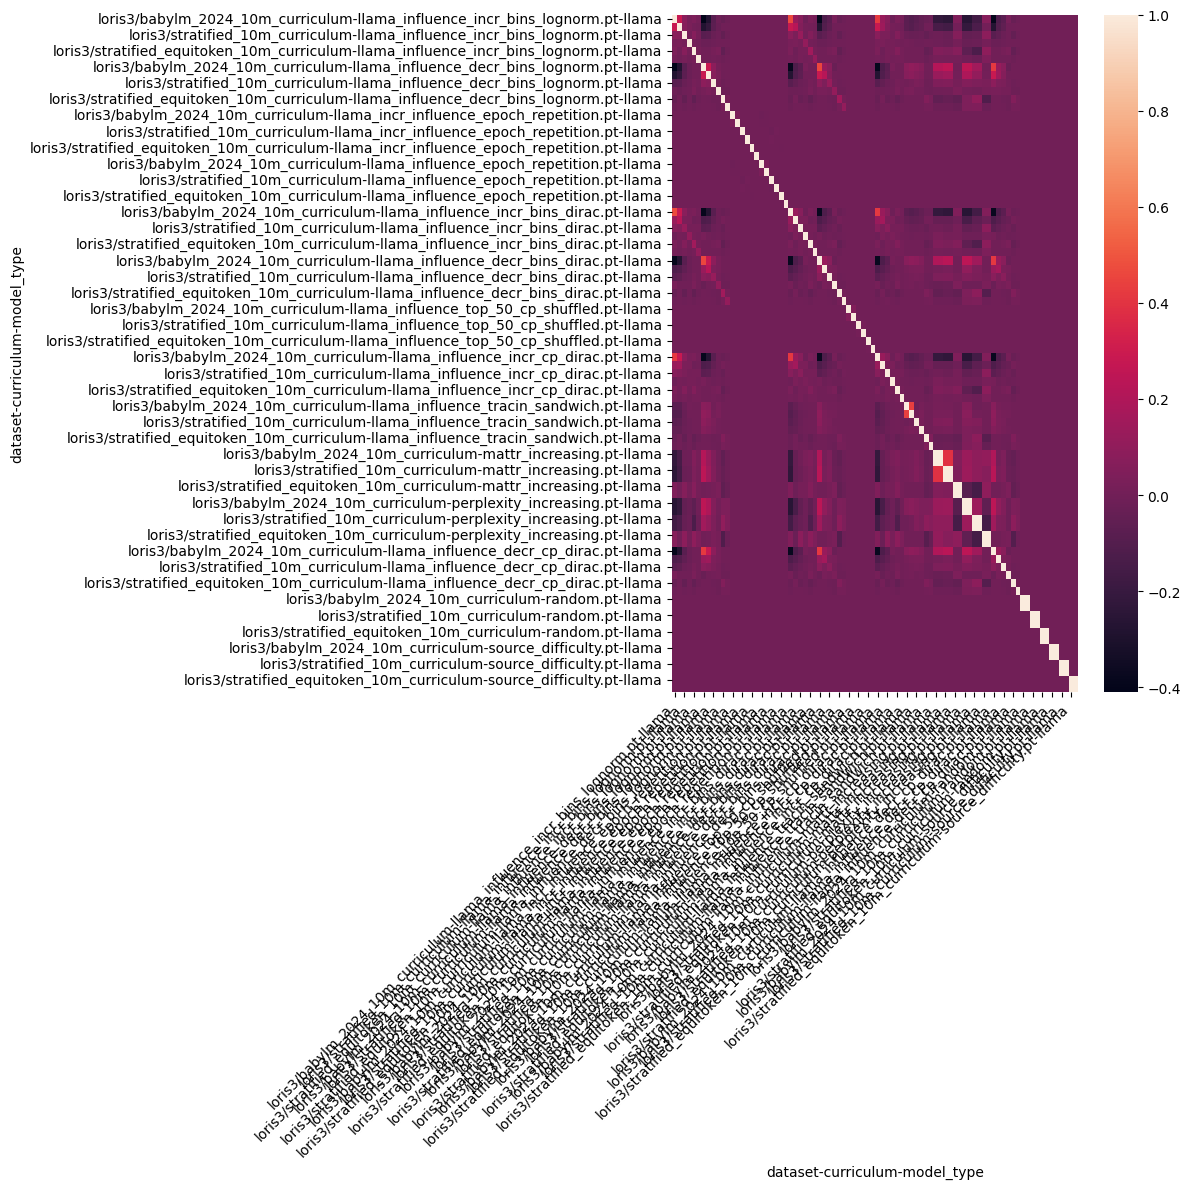

In [ ]:

plt.figure(figsize=(12, 12))
sns.heatmap(corr_df, annot=False, cbar=True)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()


In [ ]:
import util

$D_{2024}$


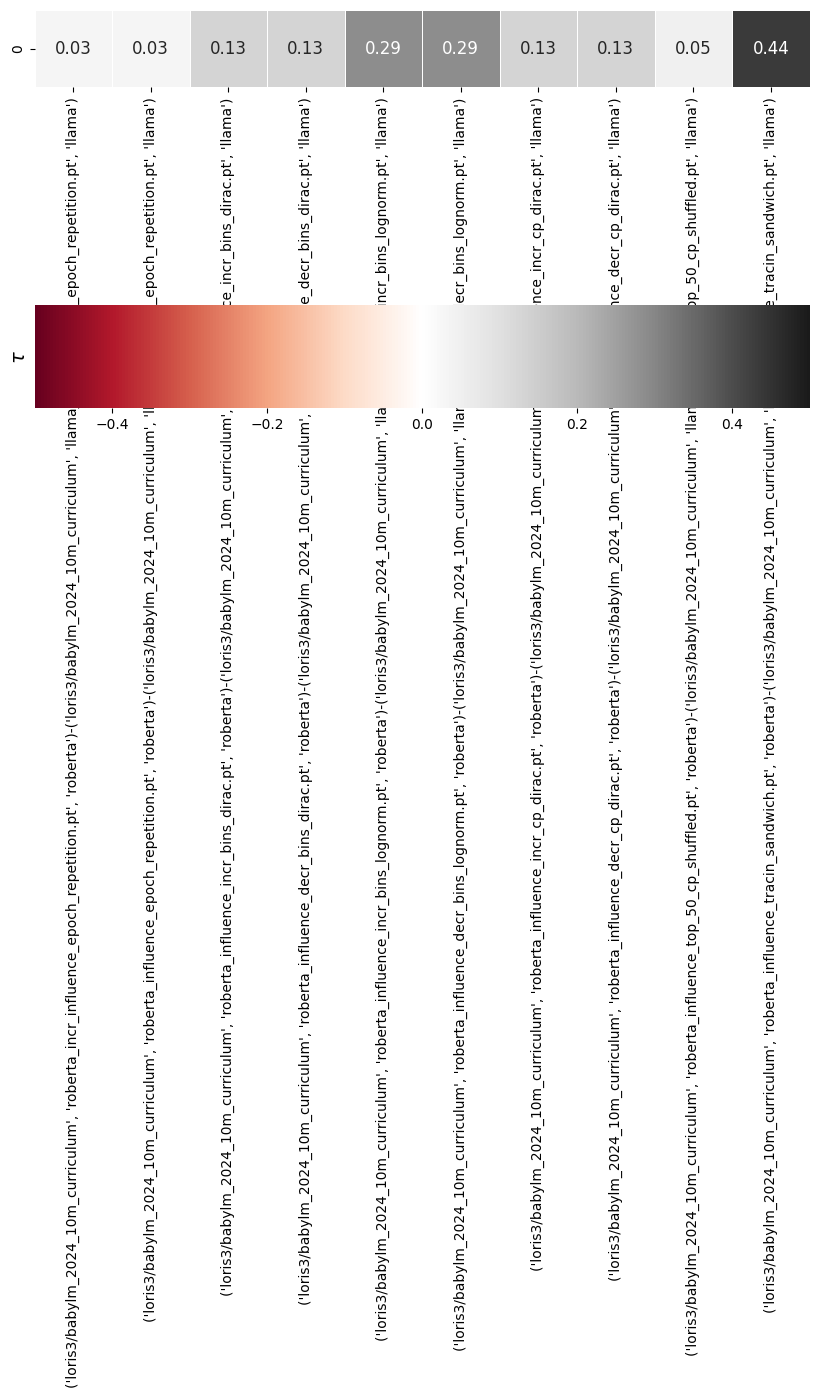

$D_{stratified}$


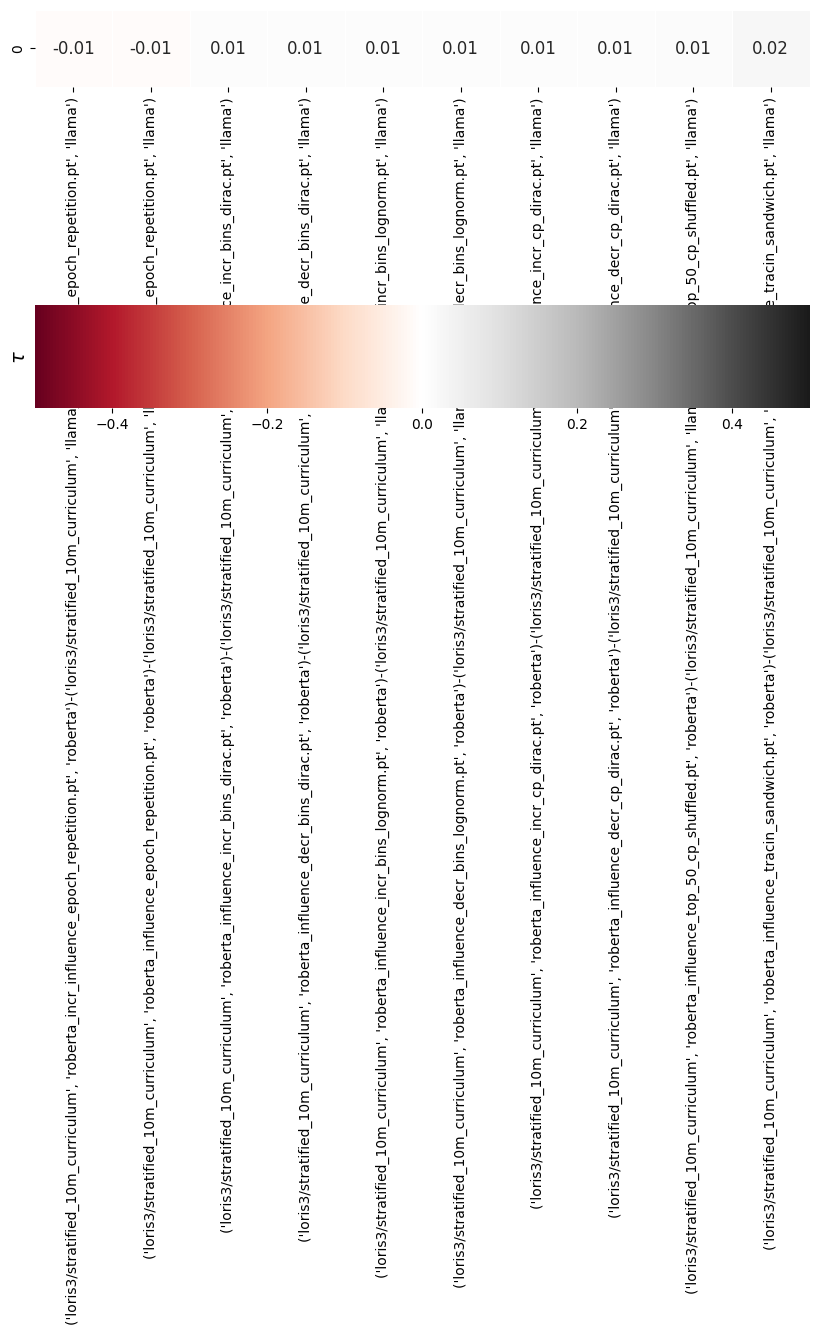

$D_{equitoken}$


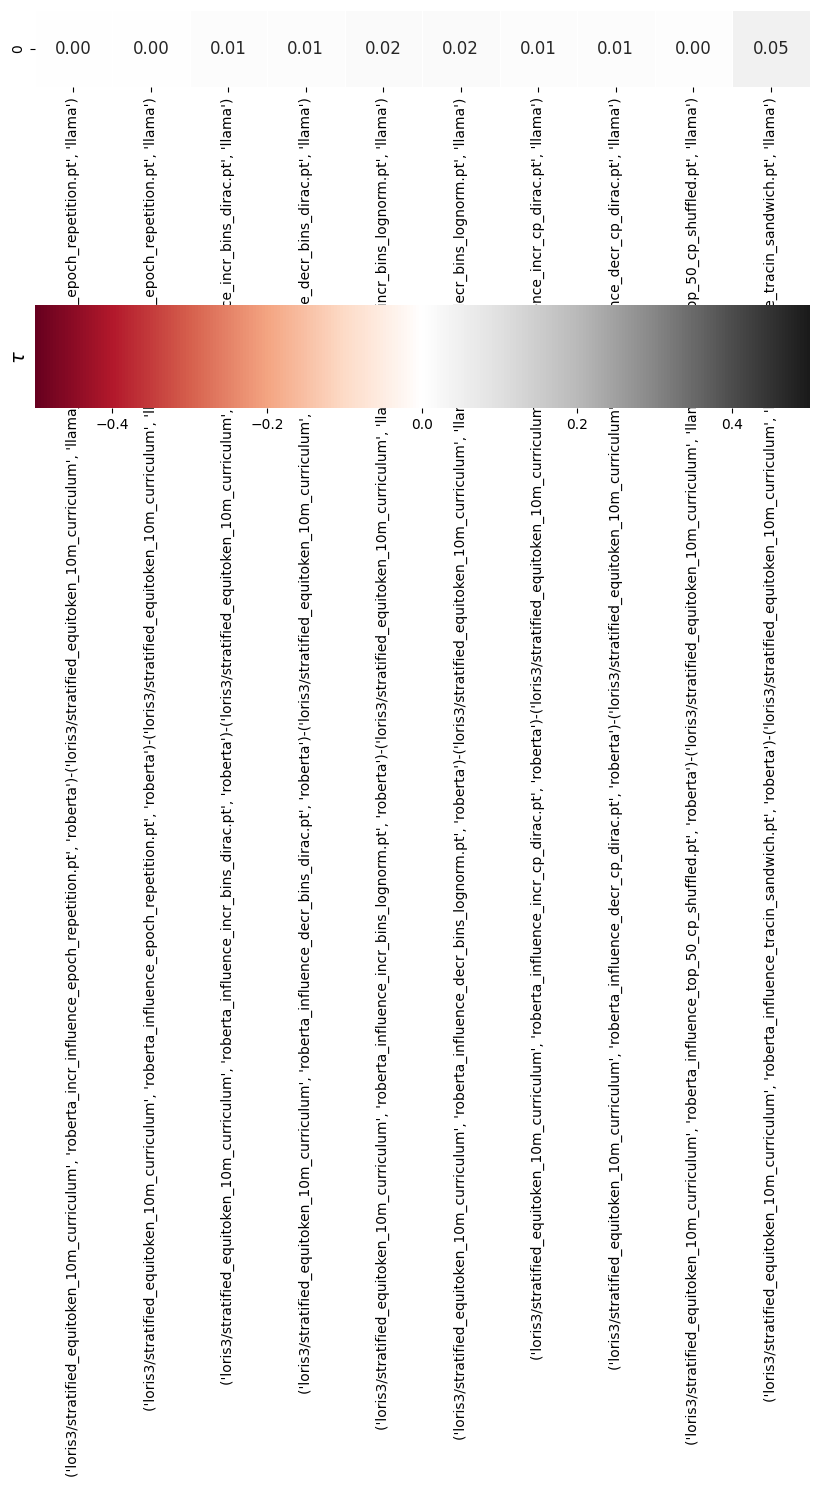

In [ ]:
# how similar are the curricula across model types?
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
import pandas as pd

all_matrices = []

unique_datasets = corr_df.index.get_level_values('dataset').unique()
unique_model_types = corr_df.index.get_level_values('model_type').unique()

for dataset in unique_datasets:

    dataset_corr = corr_df.loc[
        (dataset, ["roberta" + c for c in config.influence_curricula], "roberta"),
        (dataset, ["llama" + c for c in config.influence_curricula], "llama")
    ]



    midx = pd.MultiIndex.from_tuples(list(zip(dataset_corr.index,dataset_corr.columns)))
    dataset_corr = pd.DataFrame(data=np.diag(dataset_corr), index=midx).T


    # index_labels = [util.rename(i) for i in dataset_corr.index.get_level_values(1).unique()]
    # column_labels = [util.rename(i) for i in dataset_corr.columns.get_level_values(1).unique()]
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)
    ax = fig.add_subplot(gs[0])
    cbar_ax = fig.add_subplot(gs[1])

    sns.heatmap(
        dataset_corr,
        ax=ax,
        cbar_ax=cbar_ax,
        annot=True,
        cmap='RdGy',
        fmt='.2f',
        cbar_kws={'orientation': 'horizontal'},
        linewidths=0.5,
        annot_kws={'size': 12},
        vmin=-0.5,
        vmax=0.5
    )

   # ax.set_yticklabels(index_labels, rotation=0, fontsize=14)
    # ax.set_xticklabels(column_labels, rotation=45, fontsize=14)
    print(util.rename_dataset(dataset))
    plt.xlabel("", fontsize=14)
    plt.ylabel("$\\tau$", fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("")
    ax.set_ylabel("")

    save_path = os.path.join("./autogenerated_figures", dataset ,"kendalltau_cross_model_type.pdf")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


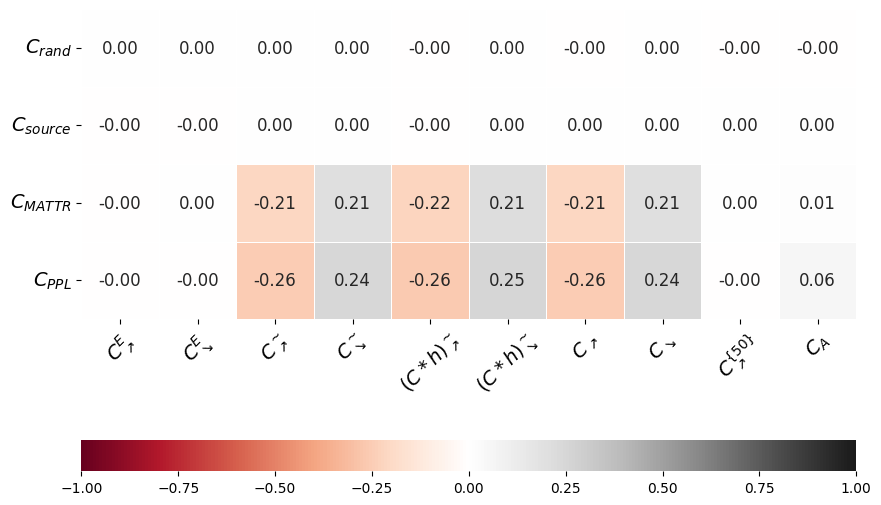

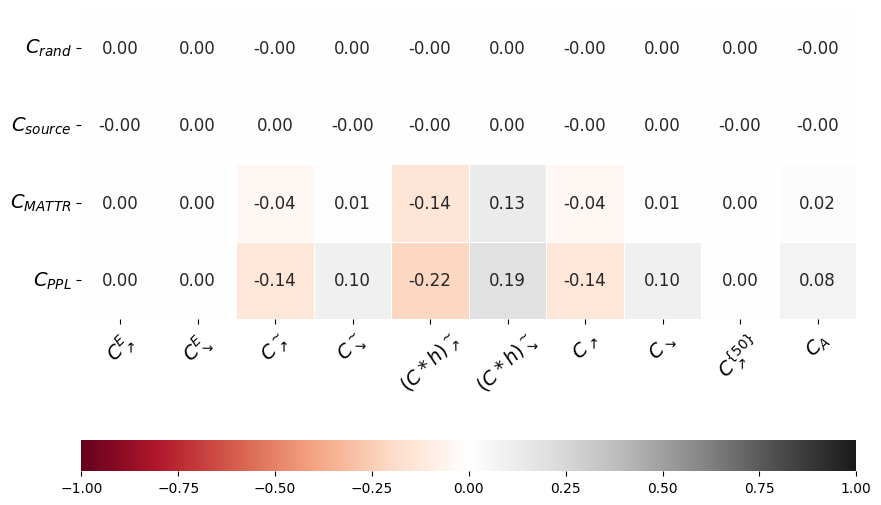

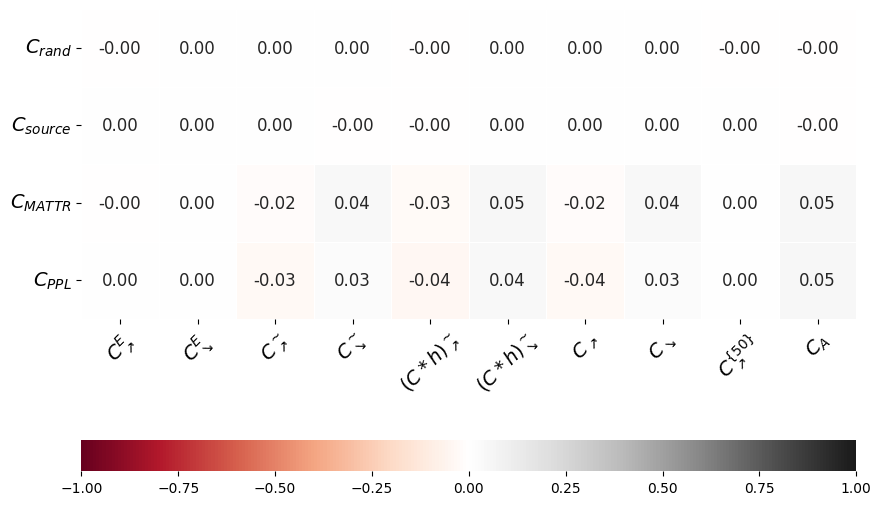

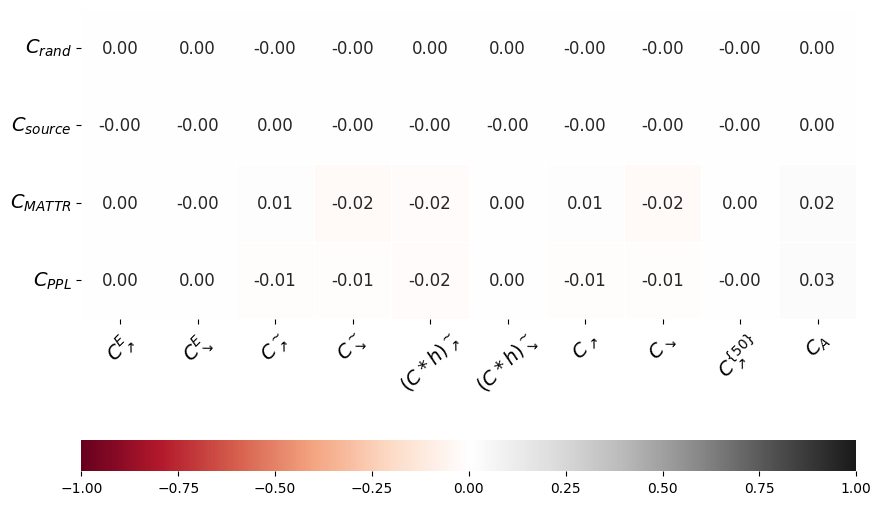

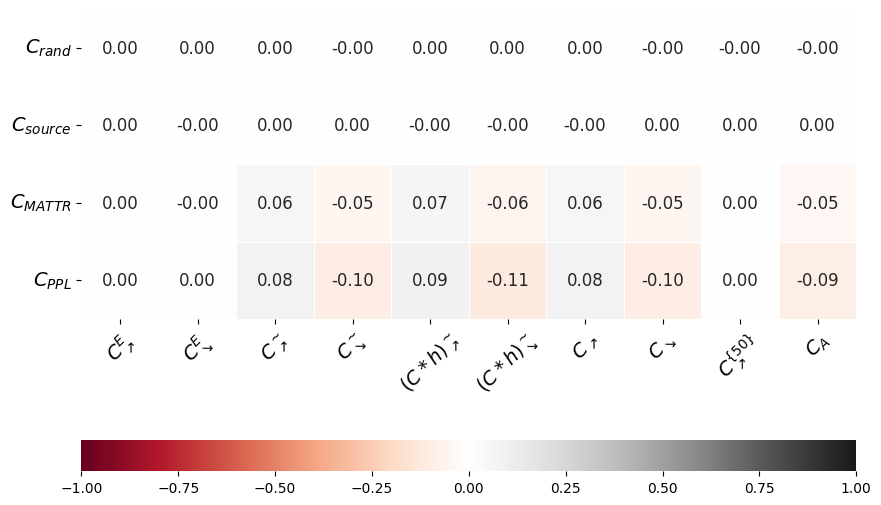

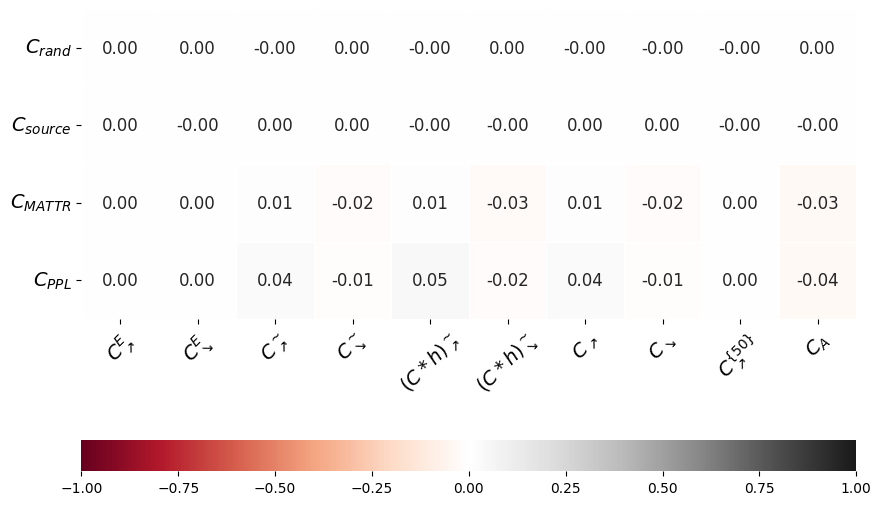

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

unique_datasets = corr_df.index.get_level_values('dataset').unique()
unique_model_types = corr_df.index.get_level_values('model_type').unique()

for dataset in unique_datasets:
    for model_type in unique_model_types:
        dataset_corr = corr_df.loc[
            (dataset, config.baseline_curricula, model_type),
            (dataset, [model_type + c for c in config.influence_curricula], model_type)
        ]

        fig = plt.figure(figsize=(10, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1], hspace=-0.10)
        ax = fig.add_subplot(gs[0])
        cbar_ax = fig.add_subplot(gs[1])

        sns.heatmap(
            dataset_corr,
            ax=ax,
            cbar_ax=cbar_ax,
            annot=True,
            cmap='RdGy',
            fmt='.2f',
            cbar_kws={'orientation': 'horizontal'},
            linewidths=0.5,
            annot_kws={'size': 12},
            vmin=-1,
            vmax=1
        )

        ax.set_yticklabels(
            [util.rename(i) for i in dataset_corr.index.get_level_values(1).unique()],
            rotation=0,
            fontsize=14
        )
        ax.set_xticklabels(
            [util.rename(i) for i in dataset_corr.columns.get_level_values(1).unique()],
            rotation=45,
            fontsize=14
        )


        plt.xlabel("", fontsize=14)
        plt.ylabel("", fontsize=14)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("")
        ax.set_ylabel("")
        save_path = os.path.join("./autogenerated_figures", "kendalltau", dataset, model_type + ".pdf")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        

        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        plt.show()


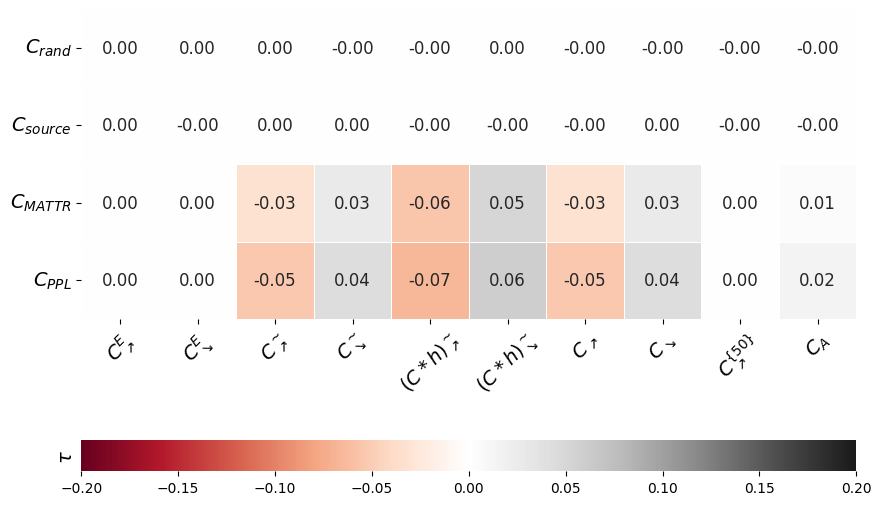

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
import pandas as pd

all_matrices = []

unique_datasets = corr_df.index.get_level_values('dataset').unique()
unique_model_types = corr_df.index.get_level_values('model_type').unique()

for dataset in unique_datasets:
    for model_type in unique_model_types:
        try:
            dataset_corr = corr_df.loc[
                (dataset, config.baseline_curricula, model_type),
                (dataset, [model_type + c for c in config.influence_curricula], model_type)
            ]
            all_matrices.append(dataset_corr.values)
        except KeyError:
            continue

mean_matrix = np.mean(all_matrices, axis=0)

example = all_matrices[0]
index_labels = [util.rename(i) for i in dataset_corr.index.get_level_values(1).unique()]
column_labels = [util.rename(i) for i in dataset_corr.columns.get_level_values(1).unique()]
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1], hspace=-0.10)
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

sns.heatmap(
    mean_matrix,
    ax=ax,
    cbar_ax=cbar_ax,
    annot=True,
    cmap='RdGy',
    fmt='.2f',
    cbar_kws={'orientation': 'horizontal'},
    linewidths=0.5,
    annot_kws={'size': 12},
    vmin=-0.2,
    vmax=0.2
)

ax.set_yticklabels(index_labels, rotation=0, fontsize=14)
ax.set_xticklabels(column_labels, rotation=45, fontsize=14)

plt.xlabel("", fontsize=14)
plt.ylabel("$\\tau$", fontsize=14)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("")
ax.set_ylabel("")

save_path = os.path.join("./autogenerated_figures", "kendalltau_mean.pdf")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()
